# Tuning SVM hyperparameters using Bayesian Optimization

In this notebook, we will use Gaussian process based Bayesian optimization to tune the hyperparameters of a SVM model with the radial basis kernel on the "spambase" dataset. We want the best hyperparameters that maximize the 5-fold cross-validation accuracy.


In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold, cross_val_score
from sklearn.datasets import fetch_openml

from gp_bo.optim.bayes_opt import BayesOpt
from gp_bo.configspace import ConfigurationSpace,CS,CSH

from typing import Dict

plt.rcParams.update({'figure.dpi':150})
plt.style.use('ggplot')

In [2]:
# set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
# fetch spambase dataset
X, y = fetch_openml('spambase', return_X_y=True,parser='auto')

# Check shapes to see if the data is loaded correctly
print(X.shape)
print(y.shape)

(4601, 57)
(4601,)


In [4]:
def accuracy_objective(config:Dict) -> float:
    '''
    Returns the 5-fold cross-validation accuracy for the given hyperparameters

    Args:
        config (Dict): Classification hyperparameters
    '''
    # classification pipeline - inputs are standardized and then
    # passed to the SVC model
    clf = Pipeline([
        ('scale', StandardScaler()),
        ('svc', SVC())]
    )
    clf.set_params(**config)

    # 5-fold CV generator. We fix the random state to ensure
    # that the same splits are used for each configuration, so that
    # the results are comparable
    cv = KFold(n_splits=5, random_state=1, shuffle=True)

    return cross_val_score(clf, X, y, cv=cv).mean()

In [5]:
config = ConfigurationSpace(seed=1234)

# Add hyperparameters to the configuration space
config.add_hyperparameters([
    CSH.UniformFloatHyperparameter('svc__C',lower=1e-5,upper=1e+5,log=True),
    CSH.UniformFloatHyperparameter('svc__gamma',lower=1e-5,upper=1e+5,log=True)
])

# Generate indices for the configuration space
config.generate_indices()
config

Configuration space object:
  Hyperparameters:
    svc__C, Type: UniformFloat, Range: [1e-05, 100000.0], Default: 1.0, on log-scale
    svc__gamma, Type: UniformFloat, Range: [1e-05, 100000.0], Default: 1.0, on log-scale

In [6]:
set_seed(1) # this will ensure reproducibility of the initial design
opt = BayesOpt(
    obj=accuracy_objective,
    config=config,
    minimize=False,
    verbose=2
)

# run optimization for 27 iterations with
# an intial design of size 4. In total, 30 
# configurations will be evaluated
out = opt.run(n_iter=27, n_init=4)

/Users/surajys/Documents/gp-bo/gp_bo/optim/bayes_opt.py:209: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  self.train_x = torch.tensor(self.train_x).double()


  iter  f_inc_obs  f_inc_est   acq_cand
     0  7.409e-01  7.409e-01  7.663e-03
     1  7.409e-01  7.409e-01  7.074e-03
     2  8.955e-01  8.926e-01  1.459e-02
     3  9.200e-01  9.200e-01  5.034e-03
     4  9.361e-01  9.360e-01  5.457e-03
     5  9.361e-01  9.351e-01  4.130e-03
     6  9.383e-01  9.381e-01  1.403e-03
     7  9.383e-01  9.381e-01  8.977e-04
     8  9.370e-01  9.381e-01  5.310e-04
     9  9.370e-01  9.380e-01  5.298e-04
  iter  f_inc_obs  f_inc_est   acq_cand
    10  9.370e-01  9.381e-01  3.859e-04
    11  9.370e-01  9.378e-01  3.595e-04
    12  9.381e-01  9.378e-01  1.011e-03
    13  9.381e-01  9.383e-01  4.799e-04
    14  9.381e-01  9.384e-01  3.490e-04
    15  9.381e-01  9.380e-01  3.096e-04
    16  9.381e-01  9.380e-01  4.022e-04
    17  9.381e-01  9.380e-01  2.700e-04
    18  9.381e-01  9.379e-01  2.313e-04
    19  9.381e-01  9.379e-01  2.179e-04
  iter  f_inc_obs  f_inc_est   acq_cand
    20  9.372e-01  9.380e-01  2.852e-04
    21  9.372e-01  9.378e-01  2.415e-04


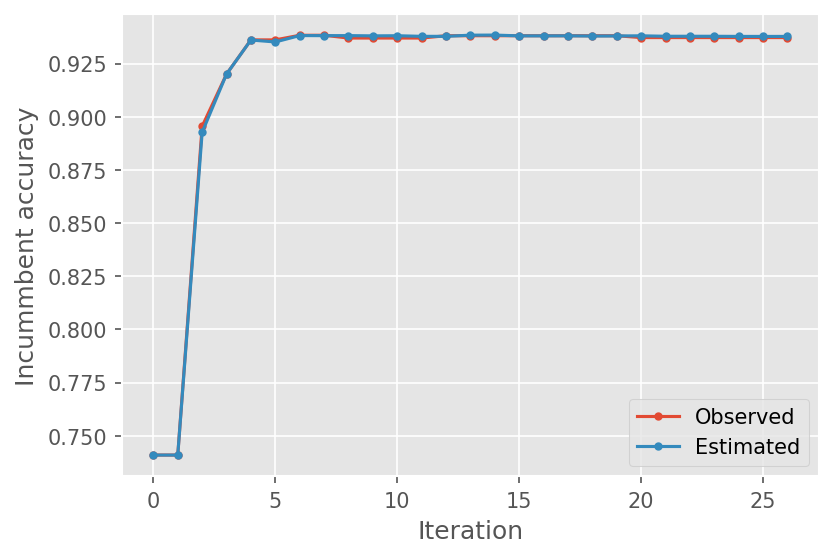

In [9]:
# plot the optimization progress
# We plot two curves - the observed accuracy of the incumbent (red) and 
# the estimated accuracy (blue). These are close, indicating that there 
# is not much noise in the objective function

fig, ax = plt.subplots(1, 1, figsize=(6,4))
_ = ax.plot(np.arange(len(opt.f_inc_est)), opt.f_inc_obs, marker='.', label=r'Observed')
_ = ax.plot(np.arange(len(opt.f_inc_est)), opt.f_inc_est, marker='.', label=r'Estimated')

_ = ax.set_xlabel('Iteration')
_ = ax.set_ylabel('Incummbent accuracy')
_ = ax.legend()


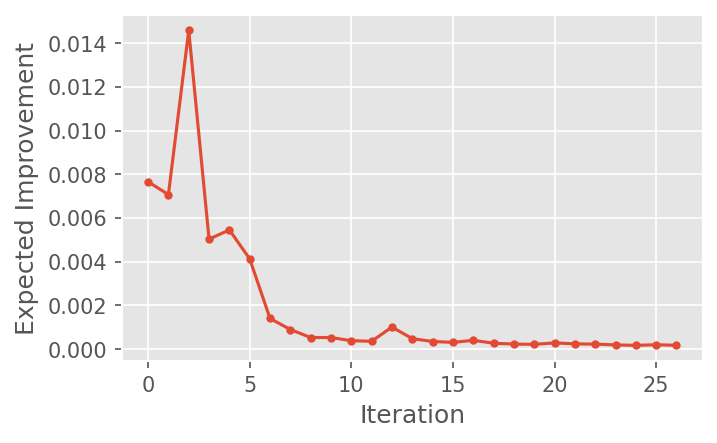

In [13]:
# Plot the expected improvement of the candidate at each iteration
# The value should eventually converge to zero. 
fig, ax = plt.subplots(1, 1, figsize=(5,3))
_ = ax.plot(np.arange(len(opt.f_inc_est)), opt.acq_vec, marker='.')
_ = ax.set_xlabel('Iteration')
_ = ax.set_ylabel('Expected Improvement')
